In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib ipympl

/home/dianloo/Desktop/tesi/quilt


In [2]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

T = 1000 # simulate for 800 ms
dt = 0.1 # ms
points_per_bin = 10      # bins 1 ms wide
sampling_frequency = 1e3 # 1 kHz sampling frequency
burn_in_millis = 300     # the first part of the record to discard (ms)

In [3]:
from quilt.builder import NeuronCatalogue, SpikingNetwork
catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

# Magic super clean params: {'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}

sn.rescale_populations(1.0)
sn.rescale_connectivity(1)
sn.rescale_weights(1.79)
sn.rescale_delays(1)

poisson_rescale = 1.97

sn.build()

Output()

In [4]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)

## Input/Output

In [5]:
# pop_state_monitorized = "FSN"
for population in sn.populations.values():
    population.monitorize_spikes()
# sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(1120, 0.45 * poisson_rescale)
sn.populations["D2"].add_poisson_spike_injector(972.927, 0.45 * poisson_rescale) 

## Run and get spikes

In [7]:
sn.run(dt=dt, time=T)

Running network consisting of 14622 neurons for 10000 timesteps
--------------------------------------------------
**************************************************
Simulation took 15 s	(1.5476 ms/step)
	Gathering time avg: 0.0343 us/step
	Inject time avg: 129.23 us/step
Population evolution stats:
	0:
		evolution:	414.638 us/step	---	69 ns/step/neuron
		spike emission:	33.4096 us/step	---	5 ns/step/neuron
	1:
		evolution:	390.479 us/step	---	65 ns/step/neuron
		spike emission:	81.3528 us/step	---	13 ns/step/neuron
	2:
		evolution:	83.5574 us/step	---	198 ns/step/neuron
		spike emission:	30.2187 us/step	---	71 ns/step/neuron
	3:
		evolution:	106.719 us/step	---	136 ns/step/neuron
		spike emission:	26.2132 us/step	---	33 ns/step/neuron
	4:
		evolution:	60.1373 us/step	---	231 ns/step/neuron
		spike emission:	5.3618 us/step	---	20 ns/step/neuron
	5:
		evolution:	69.9999 us/step	---	171 ns/step/neuron
		spike emission:	6.0816 us/step	---	14 ns/step/neuron
	6:
		evolution:	97.3473 us/step

In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

In [9]:
def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

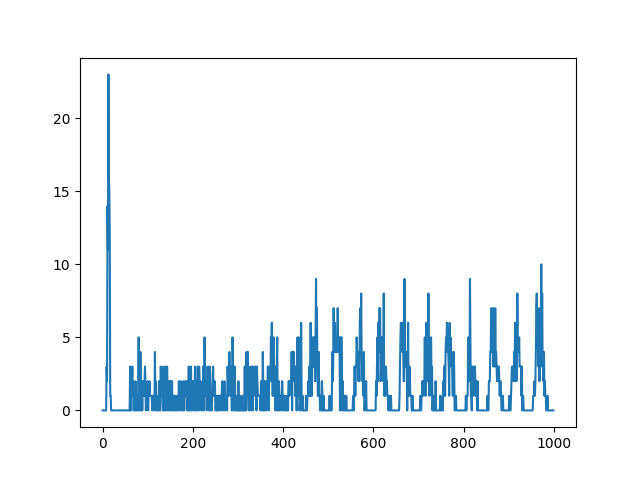

In [10]:
plt.plot(bin_spikes(spikes["D1"]))
plt.show()

In [11]:
from scipy.signal import welch

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = (T - burn_in_millis)/2, # Takes at least 3 windows
                   noverlap= (T - burn_in_millis)/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    
    beta_mask = (f>12)&(f<30)
    del sn
    return np.trapz(PSD[beta_mask], x=f[beta_mask])
beta_power(sn, "GPeTA")

12.585489653693564

In [12]:
del sn

## Tuning
Starts an optuna study to tune `poisson_rescale` and `weight_rescale`. As objective function the total beta-range power is chosen.

In [13]:
import optuna

def build_network(poisson_rescale, rescale_weights):
    
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    sn.rescale_populations(1)
    sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    sn.rescale_delays(1)
    
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    sn.run(dt=0.1, time=T)
    return beta_power(sn, "GPeTA")
    

In [14]:
set_verbosity(0) # Turns off C++ outputs

study = optuna.create_study(direction = 'maximize')
study.optimize(optimize_beta_power, n_trials = 100, n_jobs = -1, catch=(ValueError, TypeError))

[I 2024-01-25 20:00:35,353] A new study created in memory with name: no-name-2f80a6d0-9123-475d-82fa-12a14c0b8d6e
[I 2024-01-25 20:01:27,864] Trial 0 finished with value: 0.11177227556542273 and parameters: {'poisson_rescale': 1.015534922341931, 'weight_rescale': 1.8428322939644954}. Best is trial 0 with value: 0.11177227556542273.
IOStream.flush timed out
[I 2024-01-25 20:01:46,639] Trial 2 finished with value: 0.008927991794272509 and parameters: {'poisson_rescale': 0.70583278284197, 'weight_rescale': 1.269425185965664}. Best is trial 0 with value: 0.11177227556542273.
[I 2024-01-25 20:02:16,258] Trial 4 finished with value: 0.004247362924357621 and parameters: {'poisson_rescale': 0.6797264631189929, 'weight_rescale': 0.2672675649251758}. Best is trial 0 with value: 0.11177227556542273.
IOStream.flush timed out
[I 2024-01-25 20:02:48,680] Trial 1 finished with value: 0.00671828513052183 and parameters: {'poisson_rescale': 0.715475490706213, 'weight_rescale': 0.8036127539263973}. Best

## Plot best params

In [22]:
set_verbosity(1)
best_params = study.best_params

print(best_params)
print(study.best_value)

sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
sn.run(dt=0.1, time=8000)

{'poisson_rescale': 1.8572865640259018, 'weight_rescale': 1.1703015004251833}
19.121790260611625
Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 142 s	(1.7756 ms/step)
	Gathering time avg: 0.0702125 us/step
	Inject time avg: 155.273 us/step
Population evolution stats:
	0:
		evolution:	506.618 us/step	---	84 ns/step/neuron
		spike emission:	56.7619 us/step	---	9 ns/step/neuron
	1:
		evolution:	430.476 us/step	---	71 ns/step/neuron
		spike emission:	101.726 us/step	---	16 ns/step/neuron
	2:
		evolution:	86.6472 us/step	---	206 ns/step/neuron
		spike emission:	34.3995 us/step	---	81 ns/step/neuron
	3:
		evolution:	110.407 us/step	---	141 ns/step/neuron
		spike emission:	27.9546 us/step	---	35 ns/step/neuron
	4:
		evolution:	62.5096 us/step	---	240 ns/step/neuron
		spike emission:	7.59244 us/step	---	29 ns/step/neuron
	5:
		evolution:	72.721 us/step	---	178 

Mean fire rate D1 is 2.3 Hz
Mean fire rate D2 is 18.9 Hz
Mean fire rate FSN is 21.1 Hz
Mean fire rate GPeTI is 69.9 Hz
Mean fire rate GPeTA is 3.5 Hz
Mean fire rate STN is 9.4 Hz
Mean fire rate SNR is 2.5 Hz
F resolution 0.50 Hz


(0.0, 150.0)

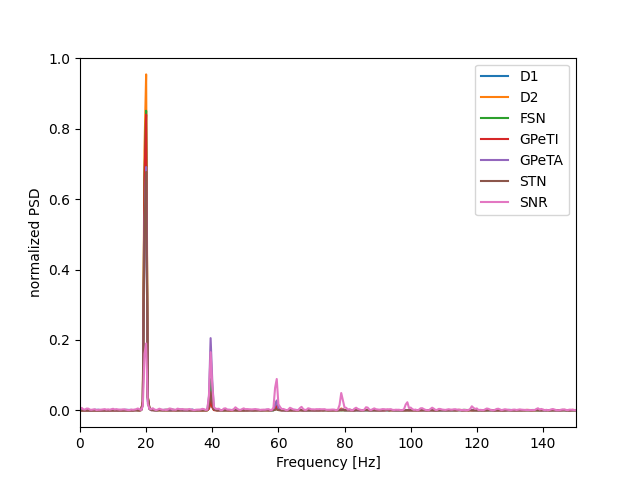

In [34]:
from scipy.integrate import simpson

timesteps_per_bin = 10
sampling_frequency = 1e4/timesteps_per_bin
fig, ax = plt.subplots()

binned_spikes = dict()
for pop in sn.populations:
    spikes = sn.populations[pop].get_data()['spikes']
    binned_spikes[pop] = bin_spikes(spikes)
    binned_spikes[pop] = binned_spikes[pop][200:]
    print(f"Mean fire rate {pop} is {np.mean(binned_spikes[pop]) :.1f} Hz")
    f, PSD = welch(binned_spikes[pop], 
                   1000, 
                   nperseg=2000, 
                   noverlap=500,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    norm = simpson(PSD, x=f)
    plt.plot(f, PSD/norm, label=pop)
print(f"F resolution { f[1] - f[0] :.2f} Hz")
# plt.yscale('log')
plt.legend()
plt.ylabel("normalized PSD")
plt.xlabel("Frequency [Hz]")
plt.xlim(0,150)

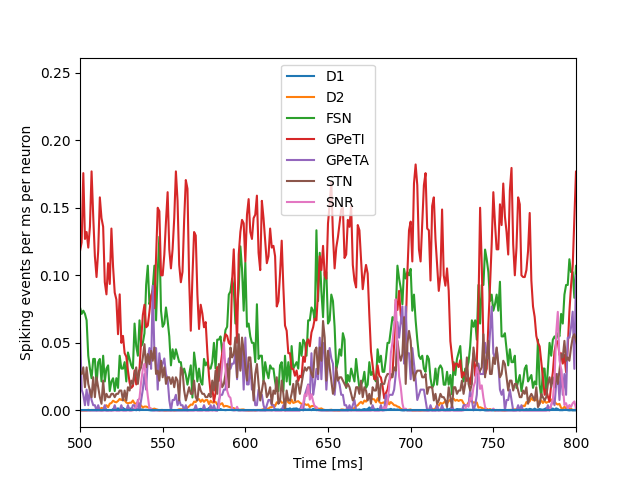

In [33]:
fig,ax = plt.subplots()
for pop in sn.populations:
    plt.plot(binned_spikes[pop]/sn.populations[pop].n_neurons, label=pop)
plt.axhline()
plt.xlabel("Time [ms]")
plt.ylabel("Spiking events per ms per neuron")
plt.xlim(500, 800)
plt.legend();

## Time signal analysis

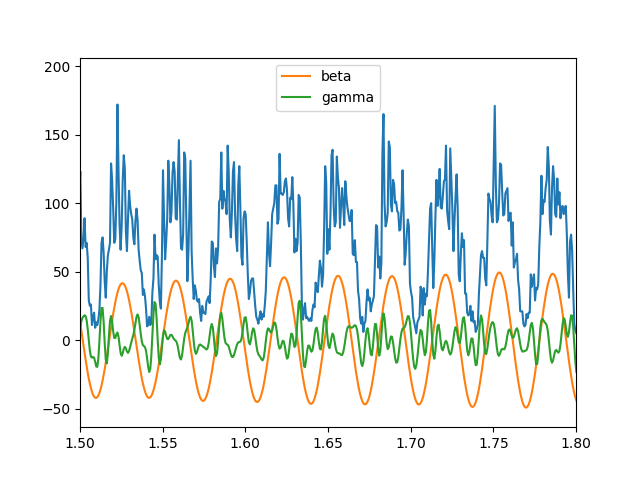

In [36]:
from scipy.signal import butter, sosfiltfilt, freqz


def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data
    
fig, ax = plt.subplots()

pop = "GPeTI"

tt = np.linspace(0, 5, len(binned_spikes[pop]))

plt.plot(tt,binned_spikes[pop])
plt.plot(tt, bandpass(binned_spikes[pop], [12, 24], 1000), label="beta")
plt.plot(tt, bandpass(binned_spikes[pop], [30, 140], 1000), label="gamma")
plt.xlim(1.50, 1.80)
plt.legend()

## Test with spectral entropy